## 1. Resolve K, R, t and K', R', t' from P and P'

In [1]:
import pygco
import numpy as np
import cv2
from PIL import Image
from pylab import *
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
DIST_NUM = 45
mLambda = 10

In [2]:
P = np.array([[1221.2270770,0.0000000,479.5000000],
             [0.0000000,1221.2270770,269.5000000],
             [0.0000000,0.0000000,1.0000000],
             [1.0000000000,0.0000000000,0.0000000000],
             [0.0000000000,1.0000000000,0.0000000000],
             [0.0000000000,0.0000000000,1.0000000000],
             [0.0000000000,0.0000000000,0.0000000000]])
Pp = np.array([[1221.2270770,0.0000000,479.5000000],
               [0.0000000,1221.2270770,269.5000000],
               [0.0000000,0.0000000,1.0000000],
               [0.9998813487,0.0148994942,0.0039106989],
               [-0.0148907594,0.9998865876,-0.0022532664],
               [-0.0039438279,0.0021947658,0.9999898146],
               [-9.9909793759,0.2451742154,0.1650832670]])
print(P, Pp)

[[1.22122708e+03 0.00000000e+00 4.79500000e+02]
 [0.00000000e+00 1.22122708e+03 2.69500000e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]] [[ 1.22122708e+03  0.00000000e+00  4.79500000e+02]
 [ 0.00000000e+00  1.22122708e+03  2.69500000e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]
 [ 9.99881349e-01  1.48994942e-02  3.91069890e-03]
 [-1.48907594e-02  9.99886588e-01 -2.25326640e-03]
 [-3.94382790e-03  2.19476580e-03  9.99989815e-01]
 [-9.99097938e+00  2.45174215e-01  1.65083267e-01]]


In [3]:
# def resolveMatrix(P):
#     # Do RQ decomposition:
#     K, R = linalg.rq(P)
#     KInverse = linalg.inv(K)
#     t = KInverse.dot(P[:, -1])
#     return K, R, t

In [4]:
# resolveMatrix(np.array([[2,2],[1,1]]))

## 2. Find X' from the Camera Matrices, and Do Graph Cut

Disparity is the times of et, thus, Disparities might need to be float for accuracy.

# generate a number of disparities as labels
def setDisparities(imgWidth, nDist):
    # Dist might need to be float
    distStep = int(imgWidth/nDist)
    dists = np.array(range(0, imgWidth, distStep))
    for eachDist in dists:
        if(eachDist!=0):
            eachDist-=1
    return dists

In [5]:
# generate a number of disparities as labels
def setDisparities1(maxDist, distStep):
    if distStep < 1:
        dists = np.array(range(0, int(maxDist*10000), int(distStep*10000)))
        dists = dists/10000
    else:   
        dists = np.array(range(0, maxDist, distStep))
    return dists

In [6]:
def getRgbDist(rgb1, rgb2):
    if(rgb1[0] > rgb2[0]):      
        rDiff = rgb1[0] - rgb2[0]
    else:
        rDiff = rgb2[0] - rgb1[0]
    if(rgb1[1] > rgb2[1]):      
        gDiff = rgb1[1] - rgb2[1]
    else:
        gDiff = rgb2[1] - rgb1[1]
    if(rgb1[2] > rgb2[2]):      
        bDiff = rgb1[2] - rgb2[2]
    else:
        bDiff = rgb2[2] - rgb1[2]
#     print((rDiff/3 + gDiff/3 + bDiff/3))
    return ((rDiff/3 + gDiff/3 + bDiff/3))
        

In [7]:
def buildGraphFromImages(img1, img2, dists, P, Pp):
    imgHeight = img1.shape[0] # range of vertical rows
    imgWidth = img1.shape[1] # range of horizontal columns
    
    nDists= dists.shape[0]
    # decompose P and P'
    K, R, T = P[0:3,:], P[3:6, :], P[6, :]
    Kp, Rp, Tp = Pp[0:3,:], Pp[3:6, :], Pp[6, :]
#     print(K, R, T)
#     print(Kp, Rp, Tp)
    mat2 = Kp.dot(np.transpose(Rp))
    mat1 = mat2.dot(R).dot(np.linalg.inv(K))
    mat3 = mat2.dot((T-Tp))
    print(mat3)
    
    #     print(Kp, Rp, Tp)
    # get prior term matrix/ pairwiseCost:
    pairwiseCost = np.zeros((nDists, nDists))
    for i in range(0, nDists):
        for j in range(0, nDists):
#             pairwiseCost[i][j] = getDist(dists[i], dists[j])
            pairwiseCost[i][j] = abs(dists[i]-dists[j])
#     print(pairwiseCost)
#     pairwiseCost = np.zeros((nDists, nDists))
    # get data term: edges, edgeWeights, unaryCosts
    nNodes = imgHeight*imgWidth
    nEdges = (2*imgHeight*imgWidth-imgHeight-imgWidth)
    
    edges = np.zeros((nEdges, 2))
    edgeWeights = np.ones((nEdges))
    unaryCosts = np.ones((nNodes, nDists))*(255)
#     print(unaryCosts)
    
    # data cost /= smoothness prior
    # for each pixel x' on img1, get corresponded x'.
    edgeIndex = 0;
    for r in range(0, imgHeight):
        for c in range(0, imgWidth):
            # build the graph from right and bottom neighbor to all pixels
            nodeNo = r*imgWidth+c
            rightNodeNo = nodeNo+1
            bottomNodeNo = nodeNo+imgWidth
            if(rightNodeNo < nNodes and c < imgWidth-1):
                edges[edgeIndex,:] = np.array([nodeNo, rightNodeNo])
                edgeIndex+=1
            if(bottomNodeNo < nNodes and r < imgHeight-1):
                edges[edgeIndex,:] = np.array([nodeNo, bottomNodeNo])
                edgeIndex+=1
            # unary cost /= data term:
            for i in range(0, nDists):
                dist = dists[i]
                # make inhomogeneous coordinate of x:
                x = np.array([r, c, 1])
                xInfinite = mat1.dot(x)
                if(xInfinite[2] != 0):
                    xInfinite = xInfinite/xInfinite[2]
#                 print("xInfinite:")
#                 print(xInfinite)
                ep = dist*mat3
#                 if(ep[2] != 0):
#                     print("raw ep:")
#                     print(ep)
#                     ep = ep/ep[2]
#                 print("ep:")
#                 print(ep)
                xp = xInfinite + ep
                # normalize x'
                xp = xp/xp[2]
#                 print("xp")
#                 print(xp)
                if (xp[0] < imgHeight and xp[0] >= 0 and xp[1] < imgWidth and xp[1] >= 0):
#                     print("yes")
                    leftNodeRGB = img1[r, c]
                    rightNodeRGB = img2[int(xp[0]), int(xp[1])]
#                     print(leftNodeRGB, rightNodeRGB)
                    unaryCosts[nodeNo,i] = getRgbDist(leftNodeRGB, rightNodeRGB)
#             print(unaryCosts[nodeNo, :])
#     for i in unaryCosts:
#         print(i)
        
    return edges, edgeWeights, unaryCosts, pairwiseCost

In [8]:
# form an image from lables:
def formImg(orgImg, dists, labels):
    imgHeight = orgImg.shape[0]
    imgWidth = orgImg.shape[1]
    output = np.zeros((imgHeight, imgWidth, 1))
    grayScaleStep = 255/dists.shape[0]
    for r in range(0, imgHeight):
        for c in range(0, imgWidth):
            label = labels[r*imgWidth+c]
            output[r][c] = label*grayScaleStep
    return output

In [9]:
leftImg = cv2.imread('test00.jpg')
leftImg = cv2.cvtColor(leftImg, cv2.COLOR_BGR2RGB)
rightImg = cv2.imread('test09.jpg')
rightImg = cv2.cvtColor(rightImg, cv2.COLOR_BGR2RGB)

In [10]:
MAX_DIST = 0.01
DIST_STEP = 0.0005

In [11]:
dists = setDisparities1(MAX_DIST, DIST_STEP)
print(dists)

[0.     0.0005 0.001  0.0015 0.002  0.0025 0.003  0.0035 0.004  0.0045
 0.005  0.0055 0.006  0.0065 0.007  0.0075 0.008  0.0085 0.009  0.0095]


In [12]:
# form an image from lables:
def formImg1(orgImg, dists, labels):
    imgHeight = orgImg.shape[0]
    imgWidth = orgImg.shape[1]
    output = np.zeros((imgHeight, imgWidth, 1))
    grayScaleStep = 255/dists.shape[0]
    print(grayScaleStep)
    for r in range(0, imgHeight):
        for c in range(0, imgWidth):
            label = labels[r*imgWidth+c]
#             print(label)
#             print(label*grayScaleStep)
            output[r][c] = (label*grayScaleStep)/255
    return output

[ 1.21449036e+04 -1.51840163e+02 -1.25457431e-01]
pairwiseCost:
[[0.     0.0005 0.001  0.0015 0.002  0.0025 0.003  0.0035 0.004  0.0045
  0.005  0.0055 0.006  0.0065 0.007  0.0075 0.008  0.0085 0.009  0.0095]
 [0.0005 0.     0.0005 0.001  0.0015 0.002  0.0025 0.003  0.0035 0.004
  0.0045 0.005  0.0055 0.006  0.0065 0.007  0.0075 0.008  0.0085 0.009 ]
 [0.001  0.0005 0.     0.0005 0.001  0.0015 0.002  0.0025 0.003  0.0035
  0.004  0.0045 0.005  0.0055 0.006  0.0065 0.007  0.0075 0.008  0.0085]
 [0.0015 0.001  0.0005 0.     0.0005 0.001  0.0015 0.002  0.0025 0.003
  0.0035 0.004  0.0045 0.005  0.0055 0.006  0.0065 0.007  0.0075 0.008 ]
 [0.002  0.0015 0.001  0.0005 0.     0.0005 0.001  0.0015 0.002  0.0025
  0.003  0.0035 0.004  0.0045 0.005  0.0055 0.006  0.0065 0.007  0.0075]
 [0.0025 0.002  0.0015 0.001  0.0005 0.     0.0005 0.001  0.0015 0.002
  0.0025 0.003  0.0035 0.004  0.0045 0.005  0.0055 0.006  0.0065 0.007 ]
 [0.003  0.0025 0.002  0.0015 0.001  0.0005 0.     0.0005 0.001  0.00

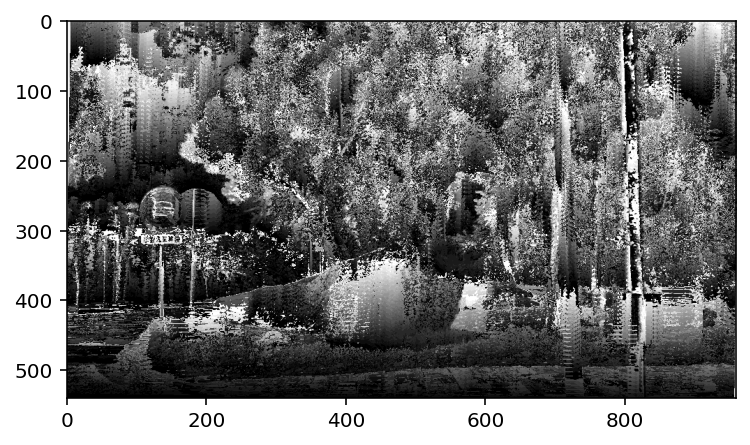

[18 18 18 ... 18 18 18]


In [13]:
edges, edgeWeights, unaryCosts, pairwiseCost  = buildGraphFromImages(leftImg, rightImg, dists, P, Pp)
# print("pairwiseCost, unaryCosts")
print("pairwiseCost:")
print(pairwiseCost)
print("unaryCost:")
print(unaryCosts)
labels = pygco.cut_general_graph(edges, mLambda*edgeWeights, unaryCosts, 1*pairwiseCost)
output = formImg1(leftImg, dists, labels)
plt.imshow(output/255, cmap = "gray")
plt.show()
print(labels)

12.75


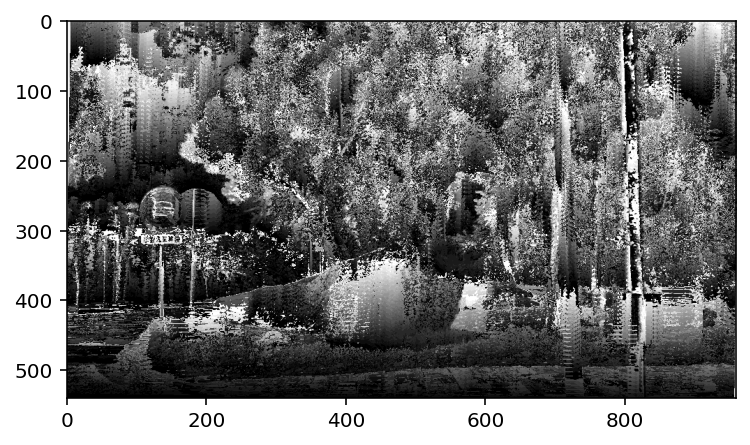

[18 18 18 ... 18 18 18]


In [18]:
# edges, edgeWeights, unaryCosts, pairwiseCost  = buildGraphFromImages(leftImg, rightImg, dists, P, Pp)
# # print("pairwiseCost, unaryCosts")
# print("pairwiseCost:")
# print(pairwiseCost)
# print("unaryCost:")
# print(unaryCosts)
labels = pygco.cut_general_graph(edges, edgeWeights, (unaryCosts/10000), pairwiseCost)
output = formImg1(leftImg, dists, labels)
plt.imshow(output/255, cmap = "gray")
plt.show()
print(labels)

12.75


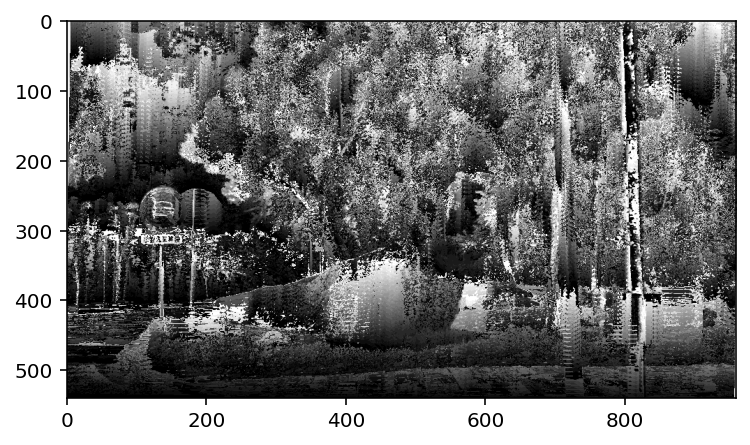

[18 18 18 ... 18 18 18]


In [19]:
# edges, edgeWeights, unaryCosts, pairwiseCost  = buildGraphFromImages(leftImg, rightImg, dists, P, Pp)
# # print("pairwiseCost, unaryCosts")
# print("pairwiseCost:")
# print(pairwiseCost)
# print("unaryCost:")
# print(unaryCosts)
labels = pygco.cut_general_graph(edges, edgeWeights, (unaryCosts/100000), pairwiseCost)
output = formImg1(leftImg, dists, labels)
plt.imshow(output/255, cmap = "gray")
plt.show()
print(labels)

[[ 0.  5. 10. 15. 20. 25. 30. 35. 40. 45. 50. 55. 60. 65. 70. 75. 80. 85.
  90. 95.]
 [ 5.  0.  5. 10. 15. 20. 25. 30. 35. 40. 45. 50. 55. 60. 65. 70. 75. 80.
  85. 90.]
 [10.  5.  0.  5. 10. 15. 20. 25. 30. 35. 40. 45. 50. 55. 60. 65. 70. 75.
  80. 85.]
 [15. 10.  5.  0.  5. 10. 15. 20. 25. 30. 35. 40. 45. 50. 55. 60. 65. 70.
  75. 80.]
 [20. 15. 10.  5.  0.  5. 10. 15. 20. 25. 30. 35. 40. 45. 50. 55. 60. 65.
  70. 75.]
 [25. 20. 15. 10.  5.  0.  5. 10. 15. 20. 25. 30. 35. 40. 45. 50. 55. 60.
  65. 70.]
 [30. 25. 20. 15. 10.  5.  0.  5. 10. 15. 20. 25. 30. 35. 40. 45. 50. 55.
  60. 65.]
 [35. 30. 25. 20. 15. 10.  5.  0.  5. 10. 15. 20. 25. 30. 35. 40. 45. 50.
  55. 60.]
 [40. 35. 30. 25. 20. 15. 10.  5.  0.  5. 10. 15. 20. 25. 30. 35. 40. 45.
  50. 55.]
 [45. 40. 35. 30. 25. 20. 15. 10.  5.  0.  5. 10. 15. 20. 25. 30. 35. 40.
  45. 50.]
 [50. 45. 40. 35. 30. 25. 20. 15. 10.  5.  0.  5. 10. 15. 20. 25. 30. 35.
  40. 45.]
 [55. 50. 45. 40. 35. 30. 25. 20. 15. 10.  5.  0.  5. 10. 15. 20.

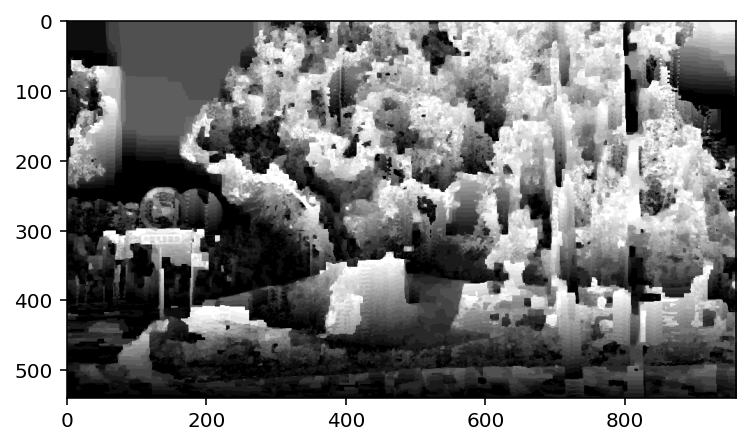

[1 1 1 ... 2 2 2]


In [25]:
# edges, edgeWeights, unaryCosts, pairwiseCost  = buildGraphFromImages(leftImg, rightImg, dists, P, Pp)
# # print("pairwiseCost, unaryCosts")
# print("pairwiseCost:")
# print(pairwiseCost)
# print("unaryCost:")
# print(unaryCosts)
newPairwiseCost = 10000*pairwiseCost
print(newPairwiseCost)
labels = pygco.cut_general_graph(edges, edgeWeights, (unaryCosts), (newPairwiseCost), n_iter=-1, algorithm= 'swap')
output = formImg1(leftImg, dists, labels)
plt.imshow(output/255, cmap = "gray")
plt.show()
print(labels)

12.75


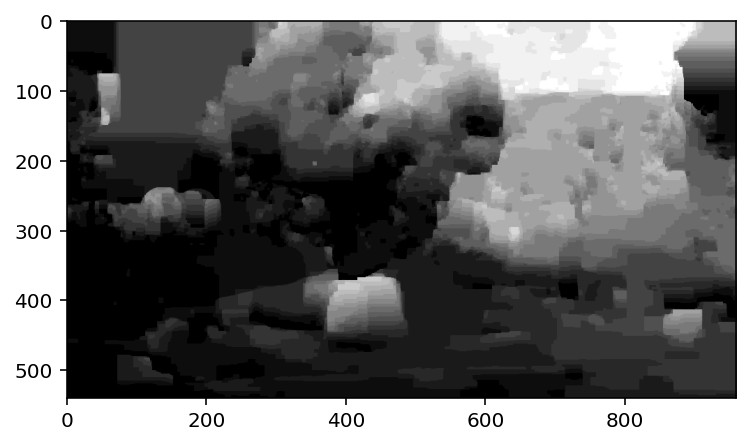

[1 1 1 ... 2 2 2]


In [27]:
# edges, edgeWeights, unaryCosts, pairwiseCost  = buildGraphFromImages(leftImg, rightImg, dists, P, Pp)
# # print("pairwiseCost, unaryCosts")
# print("pairwiseCost:")
# print(pairwiseCost)
# print("unaryCost:")
# print(unaryCosts)
newPairwiseCost = 10000*pairwiseCost
# print(newPairwiseCost)
labels = pygco.cut_general_graph(edges, 10*edgeWeights, (unaryCosts), (newPairwiseCost), n_iter=-1, algorithm= 'swap')
output = formImg1(leftImg, dists, labels)
plt.imshow(output/255, cmap = "gray")
plt.show()
print(labels)

In [29]:
MAX_DIST = 0.01
DIST_STEP = 0.0002

dists = setDisparities1(MAX_DIST, DIST_STEP)
print(dists)

[0.     0.0002 0.0004 0.0006 0.0008 0.001  0.0012 0.0014 0.0016 0.0018
 0.002  0.0022 0.0024 0.0026 0.0028 0.003  0.0032 0.0034 0.0036 0.0038
 0.004  0.0042 0.0044 0.0046 0.0048 0.005  0.0052 0.0054 0.0056 0.0058
 0.006  0.0062 0.0064 0.0066 0.0068 0.007  0.0072 0.0074 0.0076 0.0078
 0.008  0.0082 0.0084 0.0086 0.0088 0.009  0.0092 0.0094 0.0096 0.0098]


[ 1.21449036e+04 -1.51840163e+02 -1.25457431e-01]
pairwiseCost:
[[0.     0.0002 0.0004 ... 0.0094 0.0096 0.0098]
 [0.0002 0.     0.0002 ... 0.0092 0.0094 0.0096]
 [0.0004 0.0002 0.     ... 0.009  0.0092 0.0094]
 ...
 [0.0094 0.0092 0.009  ... 0.     0.0002 0.0004]
 [0.0096 0.0094 0.0092 ... 0.0002 0.     0.0002]
 [0.0098 0.0096 0.0094 ... 0.0004 0.0002 0.    ]]
unaryCost:
[[255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 ...
 [255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]]
5.1


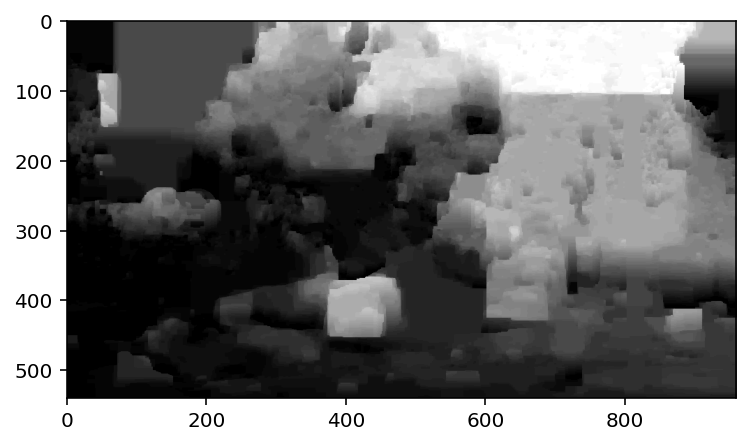

[1 1 1 ... 6 6 6]


In [30]:
edges, edgeWeights, unaryCosts, pairwiseCost  = buildGraphFromImages(leftImg, rightImg, dists, P, Pp)
# print("pairwiseCost, unaryCosts")
print("pairwiseCost:")
print(pairwiseCost)
print("unaryCost:")
print(unaryCosts)
newPairwiseCost = 10000*pairwiseCost
labels = pygco.cut_general_graph(edges, 10*edgeWeights, (unaryCosts), (newPairwiseCost), n_iter=-1, algorithm= 'swap')
output = formImg1(leftImg, dists, labels)
plt.imshow(output/255, cmap = "gray")
plt.show()
print(labels)

[ 1.21449036e+04 -1.51840163e+02 -1.25457431e-01]
pairwiseCost:
[[0.     0.0002 0.0004 ... 0.0094 0.0096 0.0098]
 [0.0002 0.     0.0002 ... 0.0092 0.0094 0.0096]
 [0.0004 0.0002 0.     ... 0.009  0.0092 0.0094]
 ...
 [0.0094 0.0092 0.009  ... 0.     0.0002 0.0004]
 [0.0096 0.0094 0.0092 ... 0.0002 0.     0.0002]
 [0.0098 0.0096 0.0094 ... 0.0004 0.0002 0.    ]]
unaryCost:
[[255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 ...
 [255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]]
5.1


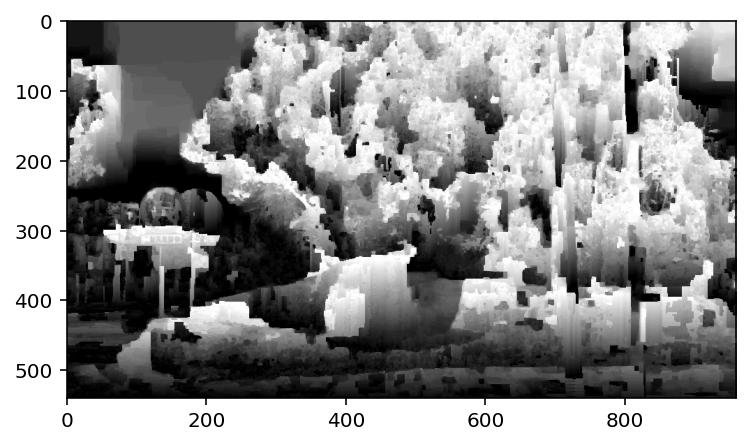

[4 4 4 ... 5 5 5]


In [31]:
edges, edgeWeights, unaryCosts, pairwiseCost  = buildGraphFromImages(leftImg, rightImg, dists, P, Pp)
# print("pairwiseCost, unaryCosts")
print("pairwiseCost:")
print(pairwiseCost)
print("unaryCost:")
print(unaryCosts)
newPairwiseCost = 10000*pairwiseCost
labels = pygco.cut_general_graph(edges, edgeWeights, (unaryCosts), (newPairwiseCost), n_iter=-1, algorithm= 'swap')
output = formImg1(leftImg, dists, labels)
plt.imshow(output/255, cmap = "gray")
plt.show()
print(labels)